In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("outputs", exist_ok=True)
os.makedirs("csv_files", exist_ok=True)


In [3]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")


In [4]:
trades.columns = trades.columns.str.strip()
sentiment.columns = sentiment.columns.str.strip()


In [5]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)
trades['date'] = trades['Timestamp IST'].dt.date


In [6]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
sentiment.rename(columns={'classification': 'Classification'}, inplace=True)


In [7]:
df = trades.merge(
    sentiment[['date', 'Classification']],
    on='date',
    how='inner'
)


In [8]:
df = df.dropna(subset=['Timestamp IST', 'Classification'])
df['Closed PnL'] = df['Closed PnL'].fillna(0)
df = df[df['Size Tokens'] > 0]


In [9]:
df['is_profitable'] = df['Closed PnL'] > 0
df['abs_pnl'] = df['Closed PnL'].abs()
df['risk_adjusted_pnl'] = df['Closed PnL'] / df['Size Tokens']


In [10]:
summary = df.groupby('Classification').agg({
    'Closed PnL': ['mean', 'median', 'std'],
    'Size Tokens': 'mean',
    'is_profitable': 'mean',
    'risk_adjusted_pnl': 'mean'
})
summary


Closed PnL                       Size Tokens is_profitable  \
                      mean median          std          mean          mean   
Classification                                                               
Extreme Fear     74.125083    0.0  1717.538504   3587.573486      0.365607   
Extreme Greed   102.968269    0.0  1094.832030  16787.269109      0.484230   
Fear             75.662241    0.0  1194.160640   4107.878516      0.449321   
Greed            57.671379    0.0  1183.038899   5268.559429      0.376338   
Neutral          53.877473    0.0   620.786356   4590.358903      0.427599   

               risk_adjusted_pnl  
                            mean  
Classification                    
Extreme Fear           47.763638  
Extreme Greed          24.176345  
Fear                   37.046521  
Greed                  20.159291  
Neutral                20.779752

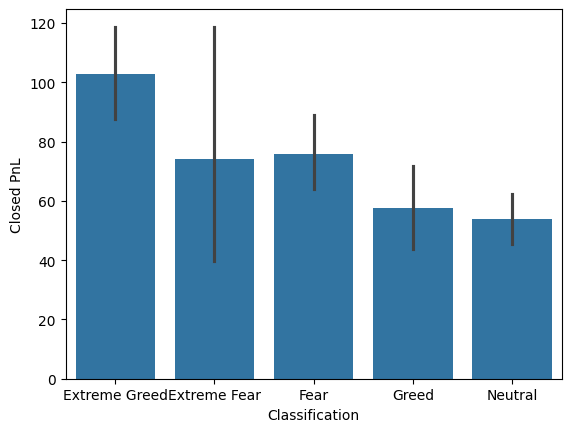

In [11]:
sns.barplot(x='Classification', y='Closed PnL', data=df, estimator=np.mean)
plt.savefig("outputs/pnl_vs_sentiment.png", dpi=300)


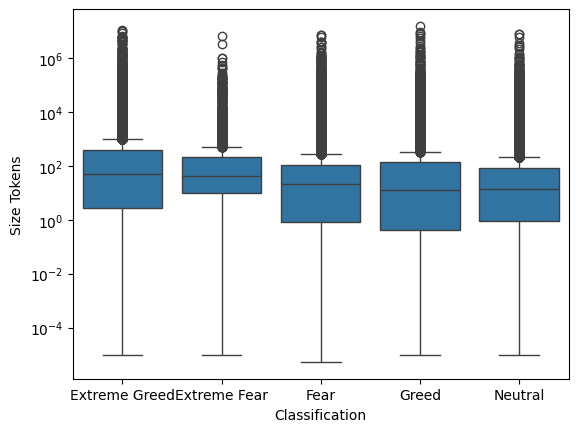

In [12]:
sns.boxplot(x='Classification', y='Size Tokens', data=df)
plt.yscale('log')
plt.savefig("outputs/trade_size_boxplot_log.png", dpi=300)


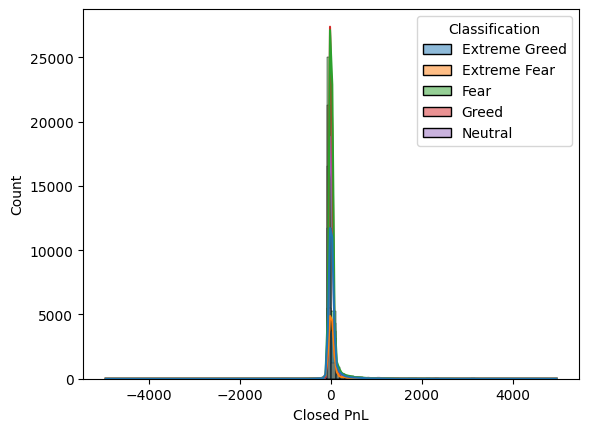

In [13]:
sns.histplot(
    df[(df['Closed PnL'] > -5000) & (df['Closed PnL'] < 5000)],
    x='Closed PnL',
    hue='Classification',
    bins=100,
    kde=True
)
plt.savefig("outputs/pnl_distribution.png", dpi=300)


In [14]:
df.to_csv("csv_files/processed_trader_sentiment_data.csv", index=False)


## Final Insights & Conclusion

### Key Observations
- Trade sizes exhibit a **heavy-tailed distribution** across all market sentiment regimes, with Greed and Extreme Greed phases showing larger upper tails, indicating increased participation from large traders.
- **Average PnL is higher during Greed phases**, but this comes with significantly higher volatility, reflecting increased risk-taking behavior.
- **Median trade-level PnL is approximately zero across all sentiment regimes**, indicating that most trades are breakeven and overall profitability is driven by infrequent large gains and losses.
- Fear and Extreme Fear periods show **wider dispersion in PnL outcomes**, suggesting emotional trading and inconsistent decision-making during market stress.

### Trading Insights
- Sentiment-aware risk controls can help mitigate overexposure during Greed-driven markets.
- Strategies that focus on **tail-risk management** are critical, as typical trades do not generate significant profits.
- Incorporating market sentiment as a contextual signal can improve consistency in trading performance.

### Conclusion
Market sentiment has a measurable impact on trader behavior, risk appetite, and performance.  
While Greed phases offer higher profit potential, they also introduce greater volatility, whereas Fear phases reflect emotional and unstable trading patterns.  
A disciplined, sentiment-aware approach to risk management is essential for sustainable trading outcomes.
